# PyStock Analyzer
---
## Algorithmic Trading program

This program implements algorithmic trading strategies to automate the buying and selling of financial instruments. It uses various technical indicators and market data to make trading decisions. The program is designed to execute trades based on predefined rules and parameters.

---


## Virtual Environment
Complete the following two steps in your command line to prepare a kernel the be used with this notebook.

#### Create a virtual environment and install required libraries:

In [1]:
# python3 -m venv venv

# source venv/bin/activate

# pip install -r requirements.txt


### Import necessary libraries:

Now the notebook can import the necessary libraries for the rest of the program.

In [2]:
import sys
import yfinance as yf
import requests
from bs4 import BeautifulSoup
from prophet import Prophet
from pandas.plotting import autocorrelation_plot
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
import pandas_datareader as pdr
import pytictoc as tt

/workspaces/AlgorithmicTrading/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


#### Define S&P 500 tickers globally:
Parses wiki for the table containing the S&P 500 list, breaks it down to an iterable list: tickers500:

In [3]:
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
response = requests.get(url)

soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table', {'id': 'constituents'})

tickers500 = []
for row in table.find_all('tr')[1:]:
    ticker = row.find('td').text.strip()
    tickers500.append(ticker)

print(tickers500)


['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BK', 'BBWI', 'BAX', 'BDX', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BX', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CHRW', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CMA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CCI', 'CSX', 'CMI', 'CVS', 'DH

---
# Ticker class
---

Using the yfinance API we can create our own Ticker class with all of the data and modules of the API available to us along with our own.

### Define Ticker class:

In [4]:
class Ticker:
    def __init__(self, symbol, start=pd.to_datetime('today') - pd.DateOffset(months=24), end=pd.to_datetime('today')):
        self.symbol = symbol
        self.start = start
        self.end = end
        if '.' in self.symbol:
            self.symbol = self.symbol.replace('.', '-')
        self.df = yf.download(self.symbol, self.start, self.end, progress=False)
        if self.df.empty:
            print("No data found for ", self.symbol)
            sys.exit(1)
        else:
            self.df = self.df.round(2)
            self.Ticker = yf.Ticker(self.symbol)
            self.actions = self.Ticker.get_actions()
            self.info = self.Ticker.get_info()
            self.financials = self.Ticker.get_financials()
            self.balance_sheet = self.Ticker.get_balance_sheet()
            self.income_statement = self.Ticker.get_income_stmt()
            self.cashflow_statement = self.Ticker.get_cashflow()
            self.calendar = self.Ticker.get_calendar()
            try:
                self.inst_holders = self.Ticker.get_institutional_holders()
            except:
                self.inst_holders = None
            # try:
            #     self.news = self.Ticker.get_news()
            # except:
            #     self.news = None
            
            try:
                if self.symbol != 'FOX' or self.symbol != 'NWS':
                    self.recommendations = self.Ticker.get_recommendations()
                else:
                    self.recommendations = None
            except:
                self.recommendations = None
            try:
                self.analysis = self.Ticker.get_analysis()
            except:
                self.analysis = None
            try:
                self.sustainability = self.Ticker.get_sustainability()
            except:
                self.sustainability = None
            try:
                self.profitability = self.get_profitability()
            except:
                self.profitability = None
            try:
                self.leverage = self.get_leverage()
            except:
                self.leverage = None
            try:
                self.operating_efficiency = self.get_operating_efficiency()
            except:
                self.operating_efficiency = None
            try:
                self.piotroski = self.get_piotroski()
            except:
                self.piotroski = None
            try:
                self.altman_z_score = self.get_altman_z_score()
            except:
                self.altman_z_score = None
            try:
                self.ratios = self.get_ratios()
            except:
                self.ratios = None
    
    
    def __str__(self):
        return self.symbol

    def __repr__(self):
        return self.symbol
    
    def get_profitability(self) -> dict:
        years = self.balance_sheet.columns

        # Score 1: - Return on Assets
        self.net_income = self.income_statement[years[0]]['NetIncome'] / 1000
        self.total_assets = self.balance_sheet[years[0]]['TotalAssets']
        self.avg_total_assets = (self.total_assets + self.balance_sheet[years[1]]['TotalAssets']) / 2
        self.rota = self.net_income / self.total_assets
        self.roaa = self.net_income / self.avg_total_assets
        roaa_score = 1 if self.roaa > 0 else 0
            
        # Score 2: Operating Cash Flow
        self.operating_cashflow = self.cashflow_statement[years[0]]['CashFlowFromContinuingOperatingActivities']
        operating_cashflow_score = 1 if self.operating_cashflow > 0 else 0

        # Score 3: Change in ROA
        avg_total_assets_py = (self.balance_sheet[years[1]]['TotalAssets'] + self.balance_sheet[years[2]]['TotalAssets']) / 2
        net_income_py = self.income_statement[years[1]]['NetIncome'] / 1000
        self.roa = self.net_income / self.avg_total_assets
        self.roa_py = net_income_py / avg_total_assets_py
        roa_score = 1 if self.roa > 0 else 0

        # Score 4: Accruals
        self.accruals = self.operating_cashflow / self.total_assets - self.roa
        ac_score = 1 if self.accruals > 0 else 0

        self.profitability_score = roaa_score + operating_cashflow_score + roa_score + ac_score

        profitability = {
            'Net Income': self.net_income,
            'ROAA': self.roaa,
            'ROAA Score': roaa_score,
            'Operating Cash Flow': self.operating_cashflow,
            'Operating Cash Flow Score': operating_cashflow_score,
            'ROA': self.roa,
            'ROA PY': self.roa_py,
            'ROA Score': roa_score,
            'Accruals': self.accruals,
            'Accruals Score': ac_score,
            'Profitability Score': self.profitability_score
        }

        return profitability

    def get_leverage(self) -> dict:
        years = self.balance_sheet.columns

        # Score 5: Change in Leverage
        try:
            self.long_term_debt = self.balance_sheet[years[0]]['LongTermDebt']
            self.total_debt = self.balance_sheet[years[0]]['TotalDebt']
            self.long_term_debt_ratio = self.long_term_debt / self.total_debt
            long_term_debt_ratio_py = self.balance_sheet[years[1]]['LongTermDebt'] / self.balance_sheet[years[1]]['TotalDebt']
            long_term_debt_score = 1 if self.long_term_debt_ratio < long_term_debt_ratio_py else 0
        except:
            long_term_debt_score = 0

        # Score 6: Change in Current Ratio
        try:
            self.current_assets = self.balance_sheet[years[0]]['CurrentAssets']
            self.current_liabilities = self.balance_sheet[years[0]]['CurrentLiabilities']
            self.current_ratio = self.current_assets / self.current_liabilities
            current_ratio_py = self.balance_sheet[years[1]]['CurrentAssets'] / self.balance_sheet[years[1]]['CurrentLiabilities']
            current_ratio_score = 1 if self.current_ratio > current_ratio_py else 0
        except:
            current_ratio_score = 0

        # Score 7: Change in number of shares
        try:
            self.shares_outstanding = self.balance_sheet[years[0]]['CommonStock']
            shares_outstanding_py = self.balance_sheet[years[1]]['CommonStock']
            shares_outstanding_score = 1 if self.shares_outstanding < shares_outstanding_py else 0
        except:
            shares_outstanding_score = 0

        self.leverage_score = long_term_debt_score + current_ratio_score + shares_outstanding_score
        try:
            leverage = {
                'Long Term Debt Ratio': self.long_term_debt_ratio,
                'Long Term Debt Score': long_term_debt_score,
                'Current Ratio': self.current_ratio,
                'Current Ratio Score': current_ratio_score,
                'Shares Outstanding': self.shares_outstanding,
                'Shares Outstanding Score': shares_outstanding_score,
                'Leverage Score': self.leverage_score
            }
        except:
            leverage = {
                'Long Term Debt Ratio': 0,
                'Long Term Debt Score': 0,
                'Leverage Score': 0,
            }

        return leverage

    def get_operating_efficiency(self) -> dict:
        years = self.balance_sheet.columns

        # Score 8: Change in Gross Margin
        try:
            self.gross_profit = self.income_statement[years[0]]['GrossProfit']
            self.revenue = self.income_statement[years[0]]['TotalRevenue']
            self.gross_margin = self.gross_profit / self.revenue
            gross_margin_py = self.income_statement[years[1]]['GrossProfit'] / self.income_statement[years[1]]['TotalRevenue']
            gross_margin_score = 1 if self.gross_margin > gross_margin_py else 0
        except:
            gross_margin_score = 0

        # Score 9: Change in Asset Turnover
        try:
            self.asset_turnover = self.revenue / self.avg_total_assets
            asset_turnover_py = self.income_statement[years[1]]['TotalRevenue'] / (self.balance_sheet[years[1]]['TotalAssets'] + self.balance_sheet[years[2]]['TotalAssets']) / 2
            asset_turnover_score = 1 if self.asset_turnover > asset_turnover_py else 0
        except:
            asset_turnover_score = 0

        # Score 10: Change in Inventory Turnover
        try:
            self.inventory = self.balance_sheet[years[0]]['Inventory']
            self.cogs = self.income_statement[years[0]]['CostOfRevenue']
            self.inventory_turnover = self.cogs / self.inventory
            inventory_turnover_py = self.income_statement[years[1]]['CostOfRevenue'] / self.balance_sheet[years[1]]['Inventory']
            self.inventory_turnover_score = 1 if self.inventory_turnover > inventory_turnover_py else 0

            self.operating_efficiency_score = gross_margin_score + asset_turnover_score 

            operating_efficiency = {
                'Gross Margin': self.gross_margin,
                'Gross Margin Score': gross_margin_score,
                'Asset Turnover': self.asset_turnover,
                'Asset Turnover Score': asset_turnover_score,
                'Inventory Turnover': self.inventory_turnover,
                'Inventory Turnover Score': self.inventory_turnover_score,
                'Operating Efficiency Score': self.operating_efficiency_score
            }
            return operating_efficiency


        except:

            self.operating_efficiency_score = 0

            operating_efficiency = {
                'Gross Margin': 0,
                'Gross Margin Score': 0,
                'Asset Turnover': 0,
                'Asset Turnover Score': 0,
                'Inventory Turnover': 0,
                'Inventory Turnover Score': 0,
                'Operating Efficiency Score': self.operating_efficiency_score
            }
            return operating_efficiency
    
    def get_financials(self) -> dict:
        self.financials = self.Ticker.financials
        return self.financials
            
    def get_ratios(self) -> dict:
        self.ratios = {}
        try:
            self.ratios['current_ratio'] = self.current_ratio
        except:
            self.ratios['current_ratio'] = 0
        self.ratios['price_earnings_ratio'] = self.info['trailingPE']
        self.ratios['projected_price_earnings_ratio'] = self.info['forwardPE']
        self.ratios['profit_sales_ratio'] = self.info['priceToSalesTrailing12Months']
        self.ratios['profit_margin'] = self.info['profitMargins']
        self.ratios['profit_book_ratio'] = self.info['priceToBook']
        # self.ratios['profit_cash_ratio'] = self.info['priceToCashflow']
        try:
            self.ratios['profit_dividend_ratio'] = self.info['dividendYield']
        except:
            self.ratios['profit_dividend_ratio'] = 0
        self.ratios['profit_earnings_growth'] = self.info['pegRatio']
        self.ratios['profit_sales_growth'] = self.info['revenueGrowth']
        return self.ratios

    def get_piotroski(self) -> dict:
        self.f_score = self.profitability['Profitability Score'] + self.leverage['Leverage Score'] + self.operating_efficiency['Operating Efficiency Score']
        
        piotroski = {
            'Profitability Score': self.profitability['Profitability Score'],
            'Leverage Score': self.leverage['Leverage Score'],
            'Operating Efficiency Score': self.operating_efficiency['Operating Efficiency Score'],
            'F-Score': self.f_score
        }
        return piotroski

    def get_altman_z_score(self):
        try:
            altman_z_score = 1.2 * self.profitability['ROAA'] + 1.4 * self.leverage['Current Ratio'] + 3.3 * self.operating_efficiency['Asset Turnover'] + 0.6 * self.leverage['Long Term Debt Ratio'] + 1.0 * self.profitability['Accruals']
            return altman_z_score
        except:
            return None
    
    def plot(self):
        plt.figure(figsize=(15, 7))
        plt.plot(self.df['Adj Close'], label=(self.symbol + " Adj Close"), color='blue')
        plt.title(self.symbol)
        plt.legend()
        plt.show()


### Ticker object
Now we create a an instance of the Ticker class to visualize some of the data we're working with.

We'll use Apple as an example here using the company ticker symbol 'AAPL', but later we will iterate over all S&P 500 companies to accrue all the data we will use in the machine learning process to refine our trading strategy.

Parameters for the ticker class are:  
Ticker(symbol, start=pd.to_datetime('today') - pd.DateOffset(months=24), end=pd.to_datetime('today'))

In [5]:
aapl = Ticker('AAPL')

print(aapl)

AAPL


##### Company info
Basic company info contained in the Ticker object:

In [6]:
aapl.info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

##### Dataframe
Ticker dataframe holds trading data from the last 24 months by derfault but this can be adjusted with the parameters listed above.

In [7]:
aapl.df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-03-11,158.93,159.28,154.50,154.73,152.98,96970100
2022-03-14,151.45,154.12,150.10,150.62,148.92,108732100
2022-03-15,150.90,155.57,150.38,155.09,153.34,92964300
2022-03-16,157.05,160.00,154.46,159.59,157.79,102300200
2022-03-17,158.61,161.00,157.63,160.62,158.81,75615400
...,...,...,...,...,...,...
2024-03-05,170.76,172.04,169.62,170.12,170.12,95132400
2024-03-06,171.06,171.24,168.68,169.12,169.12,68587700
2024-03-07,169.15,170.73,168.49,169.00,169.00,71765100


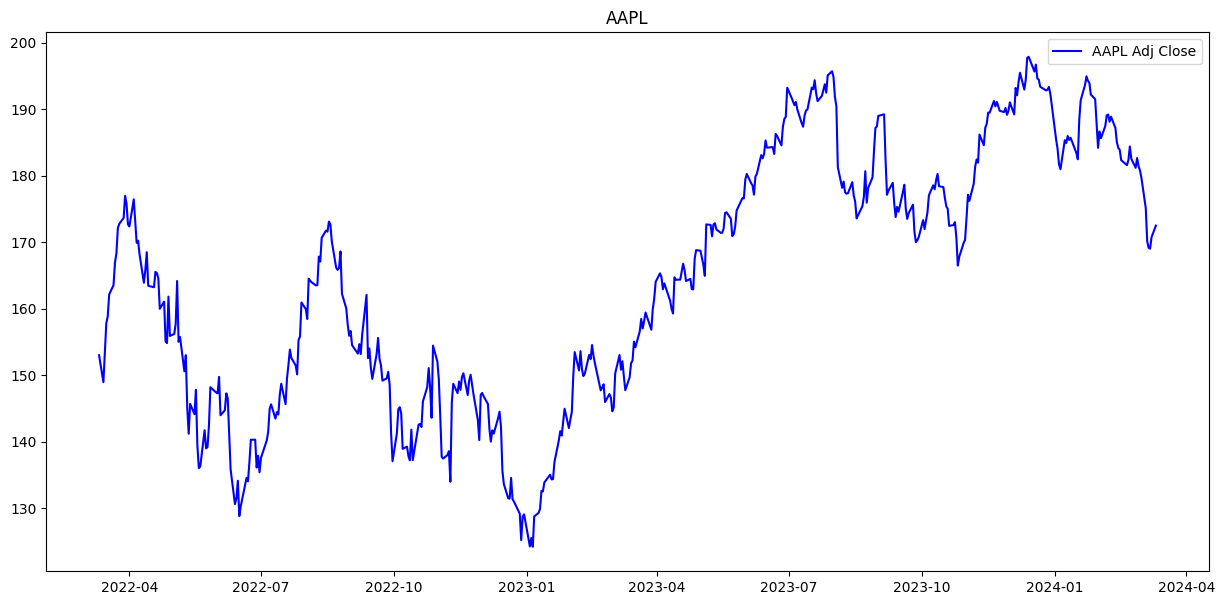

In [8]:
aapl.plot()

#### Various company fundamentals
A collection of some of the company details found on a balance sheet, cashflow statement, etc.

In [9]:
aapl.balance_sheet

,2023-09-30,2022-09-30,2021-09-30,2020-09-30
TreasurySharesNumber,0.0,NaN,NaN,NaN
OrdinarySharesNumber,15550061000.0,15943425000.0,16426786000.0,16976763000.0
ShareIssued,15550061000.0,15943425000.0,16426786000.0,16976763000.0
NetDebt,81123000000.0,96423000000.0,89779000000.0,74420000000.0
TotalDebt,111088000000.0,120069000000.0,124719000000.0,112436000000.0
...,...,...,...,...
CashCashEquivalentsAndShortTermInvestments,61555000000.0,48304000000.0,62639000000.0,90943000000.0
OtherShortTermInvestments,31590000000.0,24658000000.0,27699000000.0,52927000000.0
CashAndCashEquivalents,29965000000.0,23646000000.0,34940000000.0,38016000000.0
CashEquivalents,1606000000.0,5100000000.0,17635000000.0,20243000000.0


---
## Fundamental Analysis

---

#### [Piotroski F-score](https://en.wikipedia.org/wiki/Piotroski_F-score) 

The Piotroski F-score is used to determine a profitability score using various company financial statements as follows:

**Profitability** *Score(0 -4)*
- Return on Assets (ROA) (1 point if it is positive in the current year, 0 otherwise)
- Operating Cash Flow (1 point if it is positive in the current year, 0 otherwise)
- Change in Return of Assets (ROA) (1 point if ROA is higher in the current year compared to the previous one, 0 otherwise)
- Accruals (1 point if Operating Cash Flow/Total Assets is higher than ROA in the current year, 0 otherwise)

**Leverage, Liquidity and Source of Funds** *Score(0-3)*
- Change in Leverage (long-term) ratio (1 point if the ratio is lower this year compared to the previous one, 0 otherwise)
- Change in Current ratio (1 point if it is higher in the current year compared to the previous one, 0 otherwise)
- Change in the number of shares (1 point if no new shares were issued during the last year)

**Operating Efficiency** *Score(0-2)*
- Change in Gross Margin (1 point if it is higher in the current year compared to the previous one, 0 otherwise)
- Change in Asset Turnover ratio (1 point if it is higher in the current year compared to the previous one, 0 otherwise)

*Interpretation*
"The highest possible Piotroski score is 9 and the lowest is 0. Higher the score better the value of the company's stock. F-score of 8–9 is considered to be strong. Alternatively, firms achieving the F-score of 0–2 are considered to be weak.

Average value of Piotroski F-score can be different in different branches of economy (e.g. manufacturing, finance, etc.). This should be taken into consideration when comparing companies with different specializations."

---
These values are calculated on Ticker instantiation and many of the important figures are set to their own variables to enable easy access in further Technical Analysis in various strategies.

In [10]:
aapl.profitability

{'Net Income': 96995000.0,
 'ROAA': 0.00027503126160791,
 'ROAA Score': 1,
 'Operating Cash Flow': 110543000000.0,
 'Operating Cash Flow Score': 1,
 'ROA': 0.00027503126160791,
 'ROA PY': 0.0002836291504027669,
 'ROA Score': 1,
 'Accruals': 0.31324830934188125,
 'Accruals Score': 1,
 'Profitability Score': 4}

In [11]:
aapl.leverage

{'Long Term Debt Ratio': 0.857707403139853,
 'Long Term Debt Score': 0,
 'Current Ratio': 0.9880116717592975,
 'Current Ratio Score': 1,
 'Shares Outstanding': 73812000000.0,
 'Shares Outstanding Score': 0,
 'Leverage Score': 1}

In [12]:
aapl.operating_efficiency

{'Gross Margin': 0.4413112957720756,
 'Gross Margin Score': 1,
 'Asset Turnover': 1.0868122800699807,
 'Asset Turnover Score': 1,
 'Inventory Turnover': 33.82356657716001,
 'Inventory Turnover Score': 0,
 'Operating Efficiency Score': 2}

In [13]:
aapl.piotroski

{'Profitability Score': 4,
 'Leverage Score': 1,
 'Operating Efficiency Score': 2,
 'F-Score': 7}


#### [Altman Z-Score](https://www.investopedia.com/terms/z/zscore.asp#:~:text=Financial%20Review%20Board-,What%20Is%20Z%2DScore%3F,identical%20to%20the%20mean%20score.)
The Altman Z-score, a variation of the traditional z-score in statistics, is based on five financial ratios that can be calculated from data found on a company's annual 10-K report. It uses profitability, leverage, liquidity, solvency, and activity to predict whether a company has a high probability of becoming insolvent as follows:

Altman Z-Score = 1.2A + 1.4B + 3.3C + 0.6D + 1.0E

Where:

- A = working capital / total assets
- B = retained earnings / total assets
- C = earnings before interest and tax / total assets
- D = market value of equity / total liabilities
- E = sales / total assets

*Interpretation*
"A score below 1.8 means it's likely the company is headed for bankruptcy, while companies with scores above 3 are not likely to go bankrupt. Investors can use Altman Z-scores to determine whether they should buy or sell a stock if they're concerned about the company's underlying financial strength. Investors may consider purchasing a stock if its Altman Z-Score value is closer to 3 and selling or shorting a stock if the value is closer to 1.8.

In more recent years, however, a Z-Score closer to 0 indicates a company may be in financial trouble. In a lecture given in 2019 titled "50 Years of the Altman Score," Professor Altman himself noted that recent data has shown that 0—not 1.8—is the figure at which investors should worry about a company's financial strength"

In [14]:
aapl.altman_z_score

5.797899653433675

#### Financial Ratios
The following ratios are calculated based off company financial reports.

In [15]:
aapl.ratios

{'current_ratio': 0.9880116717592975,
 'price_earnings_ratio': 26.781055,
 'projected_price_earnings_ratio': 24.08799,
 'profit_sales_ratio': 6.904908,
 'profit_margin': 0.26163,
 'profit_book_ratio': 35.983727,
 'profit_dividend_ratio': 0.0056,
 'profit_earnings_growth': 2.37,
 'profit_sales_growth': 0.021}

---

## [Z-Score](https://www.investopedia.com/terms/z/zscore.asp#:~:text=Financial%20Review%20Board-,What%20Is%20Z%2DScore%3F,identical%20to%20the%20mean%20score.)
Z-score is a statistical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score. A Z-score of 1.0 would indicate a value that is one standard deviation from the mean. Z-scores may be positive or negative, with a positive value indicating the score is above the mean and a negative score indicating it is below the mean.

The statistical formula for a value's z-score is calculated using the following formula:

z = ( x - μ ) / σ

Where:

- z = Z-score
- x = the value being evaluated
- μ = the mean
- σ = the standard deviation

*Interpretation*
A Z-Score is a statistical measurement of a score's relationship to the mean in a group of scores.
A Z-score can reveal to a trader if a value is typical for a specified data set or if it is atypical.
In general, a Z-score of -3.0 to 3.0 suggests that a stock is trading within three standard deviations of its mean.
Traders have developed many methods that use z-score to identify correlations between trades, trading positions, and evaluate trading strategies.

---
The Z-Score can be calculated on any value to measure the relationship and whether it is typical or atypical of the data set, however the default is set to calculate based on the 'Adj Close', which is the stock price at the end of day.

In [16]:
def add_z_score(data: pd.DataFrame, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
    data['Z Score ' + frame] = (data[frame] - data[frame].rolling(window= window1).mean()) / data[frame].rolling(window= window1).std()
    data.dropna(inplace=True)
    return data

def get_z_score(data: pd.DataFrame, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
    data['Z Score ' + frame] = (data[frame] - data[frame].rolling(window= window1).mean()) / data[frame].rolling(window= window1).std()
    data.dropna(inplace=True)
    return data['Z Score ' + frame]
    

In [17]:
get_z_score(aapl.df, frame='Adj Close', window1=20)

Date
2022-04-07    0.384410
2022-04-08    0.062163
2022-04-11   -0.688429
2022-04-12   -0.583149
2022-04-13   -0.224235
                ...   
2024-03-05   -2.751871
2024-03-06   -2.391021
2024-03-07   -2.053353
2024-03-08   -1.560976
2024-03-11   -1.161835
Name: Z Score Adj Close, Length: 483, dtype: float64

---
# [Technical Analysis](https://www.investopedia.com/terms/t/technicalanalysis.asp)
---
Technical analysis is a trading discipline employed to evaluate investments and identify trading opportunities by analyzing statistical trends gathered from trading activity, such as price movement and volume. Unlike fundamental analysis, which attempts to evaluate a security's value based on business results such as sales and earnings, technical analysis focuses on the study of price and volume.


## [Technical Indicators](https://www.investopedia.com/top-7-technical-analysis-tools-4773275)
"Technical indicators are used by traders to gain insight into the supply and demand of securities and market psychology. Together, these indicators form the basis of technical analysis. Metrics, such as trading volume, provide clues as to whether a price move will continue. In this way, indicators can be used to generate buy and sell signals."

Seven of the best indicators for day trading are:

- On-balance volume (OBV)
- Accumulation/distribution (A/D) line
- Average directional index
- Aroon oscillator
- Moving average convergence divergence (MACD)
- Relative strength index (RSI)
- Stochastic oscillator

*Interpretation*
"Technical analysis is the reading of market sentiment via the use of graph patterns and signals. Various empirical studies have pointed to its effectiveness, but the range of success is varied and its accuracy remains undecided. It is best to use a suite of technical tools and indicators in tandem with other techniques like fundamental analysis to improve reliability."

--- 
## Define TechincalAnalysis class:

In [18]:
class TechnicalAnalysis:
    def __init__(self, ticker: Ticker):
        self.Ticker = ticker
        self.symbol = self.Ticker.symbol
        self.df = self.Ticker.df.copy(deep=True)
        self.df_ta = self.df.copy(deep=True)
        self.add_basic_indicators()
        self.add_bollinger_bands()
        self.add_z_score()
        self.short_term_moving_averages()
        self.long_term_moving_averages()
        self.short_exponential_moving_averages()
        self.long_exponential_moving_averages()

        # for method in dir(self):
        #     if method.startswith('add_'):
        #         df_name = method.split('add_')[1] + '_df'
        #         self.df_name = self.df.copy(deep=True)
        #         self.df_name = getattr(self, method)()
    
    def __str__(self):
        return self.symbol
    
    def __repr__(self):
        return self.symbol
    
    def add_basic_indicators(self) -> pd.DataFrame:
        self.df_ta['ma_20'] = self.df_ta['Adj Close'].rolling(window=20).mean()
        self.df_ta['vol'] = self.df_ta['Adj Close'].rolling(window=20).std()
        self.df_ta['upper_bb'] = self.df_ta['ma_20'] + (self.df_ta['vol'] * 2)
        self.df_ta['lower_bb'] = self.df_ta['ma_20'] - (self.df_ta['vol'] * 2)
        self.df_ta['rsi'] = ta.momentum.rsi(self.df_ta['Adj Close'], window=6)

    def add_bollinger_bands(self) -> pd.DataFrame:
        self.df_ta['BollingerBandHigh'] = self.df_ta['ma_20'] + (self.df_ta['vol'] * 2)
        self.df_ta['BollingerBandLow'] = self.df_ta['ma_20'] - (self.df_ta['vol'] * 2)
        self.df_ta['BollingerMAvg'] = ta.volatility.bollinger_mavg(self.df_ta['Adj Close'], window=20)
        self.df_ta['Bollinger%b'] = ta.volatility.bollinger_pband(self.df_ta['Adj Close'])
        self.df_ta['Bollinger Width'] = ta.volatility.bollinger_wband(self.df['Adj Close'])

    def add_z_score(self, frame: str = 'Adj Close', window1 = 20) -> pd.DataFrame:
        self.df_ta['Z Score ' + frame] = (self.df[frame] - self.df[frame].rolling(window= window1).mean()) / self.df[frame].rolling(window= window1).std()
        return self.df_ta

    def short_term_moving_averages(self) -> pd.DataFrame:
        self.df_short_sma = self.df.copy(deep=True)
        self.df_short_sma['SMA_10'] = ta.trend.sma_indicator(self.df['Adj Close'], window=10)
        self.df_short_sma['SMA_20'] = ta.trend.sma_indicator(self.df['Adj Close'], window=20)
        self.df_short_sma['SMA_30'] = ta.trend.sma_indicator(self.df['Adj Close'], window=30)
        return self.df_short_sma

    def long_term_moving_averages(self) -> pd.DataFrame:
        self.df_long_sma = self.df.copy(deep=True)
        self.df_long_sma['SMA_50'] = ta.trend.sma_indicator(self.df['Adj Close'], window=50)
        self.df_long_sma['SMA_100'] = ta.trend.sma_indicator(self.df['Adj Close'], window=100)
        self.df_long_sma['SMA_200'] = ta.trend.sma_indicator(self.df['Adj Close'], window=200)
        return self.df_long_sma

    def short_exponential_moving_averages(self) -> pd.DataFrame:
        self.df_short_exponential = self.df.copy(deep=True)
        self.df_short_exponential['EMA_10'] = ta.trend.ema_indicator(self.df['Adj Close'], window=10)
        self.df_short_exponential['EMA_20'] = ta.trend.ema_indicator(self.df['Adj Close'], window=20)
        self.df_short_exponential['EMA_30'] = ta.trend.ema_indicator(self.df['Adj Close'], window=30)
        return self.df_short_exponential

    def long_exponential_moving_averages(self) -> pd.DataFrame:
        self.df_long_exponential = self.df.copy(deep=True)
        self.df_long_exponential['EMA_50'] = ta.trend.ema_indicator(self.df['Adj Close'], window=50)
        self.df_long_exponential['EMA_100'] = ta.trend.ema_indicator(self.df['Adj Close'], window=100)
        self.df_long_exponential['EMA_200'] = ta.trend.ema_indicator(self.df['Adj Close'], window=200)
        return self.df_long_exponential

    def add_macd(self) -> pd.DataFrame:
        self.df_ta['MACD'] = ta.trend.macd_diff(self.df['Adj Close'])
        self.df_ta['MACD Signal'] = ta.trend.macd_signal(self.df['Adj Close'])
        self.df_ta['MACD Histogram'] = ta.trend.macd_diff(self.df['Adj Close']) - ta.trend.macd_signal(self.df['Adj Close'])

    def add_keltner_channels(self) -> pd.DataFrame:
        self.df_ta['KeltnerH'] = ta.volatility.keltner_channel_hband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['KeltnerL'] = ta.volatility.keltner_channel_lband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['KeltnerWidth'] = ta.volatility.keltner_channel_wband(self.df['High'], self.df['Low'], self.df['Adj Close'])

    def add_donchian_channels(self) -> pd.DataFrame:
        self.df_ta['DonchianH'] = ta.volatility.donchian_channel_hband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['DonchianL'] = ta.volatility.donchian_channel_lband(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['DonchianWidth'] = ta.volatility.donchian_channel_wband(self.df['High'], self.df['Low'], self.df['Adj Close'])

    def add_vortex_indicator(self) -> pd.DataFrame:
        self.df_ta['Vortex+'] = ta.trend.vortex_indicator_pos(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['Vortex-'] = ta.trend.vortex_indicator_neg(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['VortexSignal'] = self.df['Vortex+'] - self.df['Vortex-']

    def add_ichimoku_cloud(self) -> pd.DataFrame:
        self.df_ta['IchimokuA'] = ta.trend.ichimoku_a(self.df['High'], self.df['Low'])
        self.df_ta['IchimokuB'] = ta.trend.ichimoku_b(self.df['High'], self.df['Low'])
        self.df_ta['IchimokuBaseLine'] = ta.trend.ichimoku_base_line(self.df['High'], self.df['Low'])
        self.df_ta['IchimokuConvLine'] = ta.trend.ichimoku_conversion_line(self.df['High'], self.df['Low'])

    def add_aroon(self) -> pd.DataFrame:
        self.df_ta['AroonUp'] = ta.trend.aroon_up(self.df['High'], self.df['Low'])
        self.df_ta['AroonDown'] = ta.trend.aroon_down(self.df['High'], self.df['Low'])
        self.df_ta['AroonInd'] = self.df['AroonUp'] - self.df['AroonDown']

    def add_kst(self) -> pd.DataFrame:
        self.df_ta['KST'] = ta.trend.kst(self.df['Adj Close'])
        self.df_ta['KSTsig'] = ta.trend.kst_sig(self.df['Adj Close'])
        self.df_ta['KSTdiff'] = self.df['KST'] - self.df['KSTsig']

    def add_momentum_indicators(self) -> pd.DataFrame:
        self.df_ta['RSI'] = ta.momentum.rsi(self.df['Adj Close'], window=6)
        self.df_ta['TSI'] = ta.momentum.tsi(self.df['Adj Close'])
        self.df_ta['Awesome Oscillator'] = ta.momentum.awesome_oscillator(self.df['High'], self.df['Low'])
        self.df_ta['Ultimate Oscillator'] = ta.momentum.ultimate_oscillator(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['Stoch'] = ta.momentum.stoch(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['Stoch Signal'] = ta.momentum.stoch_signal(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['Williams %R'] = ta.momentum.williams_r(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['KAMA'] = ta.momentum.kama(self.df['Adj Close'])
        self.df_ta['PPO'] = ta.momentum.ppo(self.df['Adj Close'])
        self.df_ta['ROC'] = ta.momentum.roc(self.df['Adj Close'])

    def add_trend_indicators(self) -> pd.DataFrame:
        self.df_ta['ADX'] = ta.trend.adx(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['CCI'] = ta.trend.cci(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['DPO'] = ta.trend.dpo(self.df['Adj Close'])
        self.df_ta['EMA'] = ta.trend.ema_indicator(self.df['Adj Close'])
        self.df_ta['Ichimoku'] = ta.trend.ichimoku_a(self.df['High'], self.df['Low'])
        self.df_ta['KST'] = ta.trend.kst(self.df['Adj Close'])
        self.df_ta['MACD'] = ta.trend.macd_diff(self.df['Adj Close'])
        self.df_ta['Mass Index'] = ta.trend.mass_index(self.df['High'], self.df['Low'])
        self.df_ta['Parabolic SAR'] = ta.trend.psar_up(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['TRIX'] = ta.trend.trix(self.df['Adj Close'])
        self.df_ta['Stooq'] = ta.trend.stc(self.df['Adj Close'])

    def add_volume_indicators(self) -> pd.DataFrame:
        self.df_ta['VWAP'] = ta.volume.volume_weighted_average_price(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df_ta['ForceIndex'] = ta.volume.force_index(self.df['Adj Close'], self.df['Volume'])
        self.df_ta['Accumulation/Distribution'] = ta.volume.acc_dist_index(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df_ta['Chaikin'] = ta.volume.chaikin_money_flow(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df_ta['EOM'] = ta.volume.ease_of_movement(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df_ta['FI'] = ta.volume.force_index(self.df['Adj Close'], self.df['Volume'])
        self.df_ta['MFI'] = ta.volume.money_flow_index(self.df['High'], self.df['Low'], self.df['Adj Close'], self.df['Volume'])
        self.df_ta['OBV'] = ta.volume.on_balance_volume(self.df['Adj Close'], self.df['Volume'])
        self.df_ta['VPT'] = ta.volume.volume_price_trend(self.df['Adj Close'], self.df['Volume'])

    def add_volatility_indicators(self) -> pd.DataFrame:
        self.df_ta['ATR'] = ta.volatility.average_true_range(self.df['High'], self.df['Low'], self.df['Adj Close'])
        self.df_ta['Ulcer Index'] = ta.volatility.ulcer_index(self.df['Adj Close'])

    def plot_z_score(self):
        plt.figure(figsize=(20, 10))
        self.z_score_df = self.df[['Adj Close', 'Z Score Adj Close']].copy(deep=True)
        self.z_score_df.dropna(inplace=True)
        plt.plot(self.z_score_df['Adj Close'], label=self.Ticker.symbol, alpha=1, color='black')
        plt.plot(self.z_score_df['Z Score Adj Close'], label='Z Score', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()

    def plot_short_sma(self):
        plt.figure(figsize=(20, 10))
        self.short_sma_df = self.df[['Adj Close', 'SMA_10', 'SMA_20', 'SMA_30']].copy(deep=True)
        self.short_sma_df.dropna(inplace=True)
        plt.plot(self.short_sma_df['Adj Close'], label=self.Ticker.symbol, alpha=1, color='black')
        plt.plot(self.short_sma_df['SMA_10'], label='SMA 10', alpha=0.5)
        plt.plot(self.short_sma_df['SMA_20'], label='SMA 20', alpha=0.5)
        plt.plot(self.short_sma_df['SMA_30'], label='SMA 30', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()

    def plot_long_sma(self):
        plt.figure(figsize=(20, 10))
        self.long_sma_df = self.df[['Adj Close', 'SMA_50', 'SMA_100', 'SMA_200']].copy(deep=True)
        self.long_sma_df.dropna(inplace=True)
        plt.plot(self.long_sma_df['Adj Close'], label=self.Ticker.symbol, alpha=1, color='black')
        plt.plot(self.long_sma_df['SMA_50'], label='SMA 50', alpha=0.5)
        plt.plot(self.long_sma_df['SMA_100'], label='SMA 100', alpha=0.5)
        plt.plot(self.long_sma_df['SMA_200'], label='SMA 200', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()


    def plot_macd(self):
        plt.figure(figsize=(20, 10))
        self.macd_df = self.df[['MACD', 'MACD Signal', 'MACD Histogram']].copy(deep=True)
        self.macd_df.dropna(inplace=True)
        plt.plot(self.macd_df['MACD'], label='MACD', alpha=1, color='black')
        plt.plot(self.macd_df['MACD Signal'], label='MACD Signal', alpha=0.5)
        plt.bar(self.macd_df.index, self.macd_df['MACD Histogram'], label='MACD Histogram', alpha=0.5)
        plt.legend()
        plt.show()
        plt.close()


    def plot_bollinger_bands(self):
        plt.figure(figsize=(20, 10))
        self.df_ta.dropna(inplace=True)
        plt.plot(self.df_ta['Adj Close'], label=self.Ticker.symbol, alpha=1)
        plt.plot(self.df_ta['ma_20'], label='Moving Avg(20 day)', alpha=0.70)
        plt.plot(self.df_ta['upper_bb'], label='Bollinger Band High', alpha=0.55)
        plt.plot(self.df_ta['lower_bb'], label='Bollinger Band Low', alpha=0.55)
        plt.legend()
        plt.show()
        plt.close()

    def generate_correlation_matrix(self):
        self.df.dropna(inplace=True)
        self.correlation_matrix = self.df.corr()
        return self.correlation_matrix

    def autocorrelation_plot(self):
        self.autocorrelation_df = self.df[['Adj Close']].copy(deep=True)
        self.autocorrelation_df.dropna(inplace=True)
        autocorrelation_plot(self.autocorrelation_df)
        plt.show()
        plt.close()

    # def generate_prophet_forecast(self, frame= 'Adj Close' ,period=90):
    #     self.prophet_df = self.df[[frame]].copy(deep=True)
    #     self.prophet_df = self.prophet_df.reset_index()
    #     self.prophet_df = self.prophet_df.rename(columns={'Date': 'ds', frame: 'y'})
    #     self.model = Prophet()
    #     self.model.fit(self.prophet_df)
    #     self.future = self.model.make_future_dataframe(periods= period)
    #     self.forecast = self.model.predict(self.future)
    #     self.model.plot(self.forecast)
    #     self.model.plot_components(self.forecast)
    #     plt.show()
    #     plt.close()

### Technical Analysis object
Now we create a an instance of the Ticker class to visualize the technical analysis data we now have available:

In [19]:
aapl_ta = TechnicalAnalysis(aapl)

print(aapl_ta)

AAPL


##### Dataframe
The TechnicalAnalysis dataframe includes original dataframe info as well as all of the technical indicators calculated during instantiation.
Each inidicator type is saved in it's own dataframe and plot ready to be visualized.

In [20]:
# aapl_ta.df.dropna(inplace=True)
aapl_ta.df

,Open,High,Low,Close,Adj Close,Volume,Z Score Adj Close
Date,,,,,,,
2022-04-07,171.16,173.36,169.85,172.14,170.20,77594700,0.384410
2022-04-08,171.78,171.78,169.20,170.09,168.17,76575500,0.062163
2022-04-11,168.71,169.03,165.50,165.75,163.88,72246700,-0.688429
2022-04-12,168.02,169.87,166.64,167.66,165.77,79265200,-0.583149
2022-04-13,167.39,171.04,166.77,170.40,168.47,70618900,-0.224235
...,...,...,...,...,...,...,...
2024-03-05,170.76,172.04,169.62,170.12,170.12,95132400,-2.751871
2024-03-06,171.06,171.24,168.68,169.12,169.12,68587700,-2.391021
2024-03-07,169.15,170.73,168.49,169.00,169.00,71765100,-2.053353


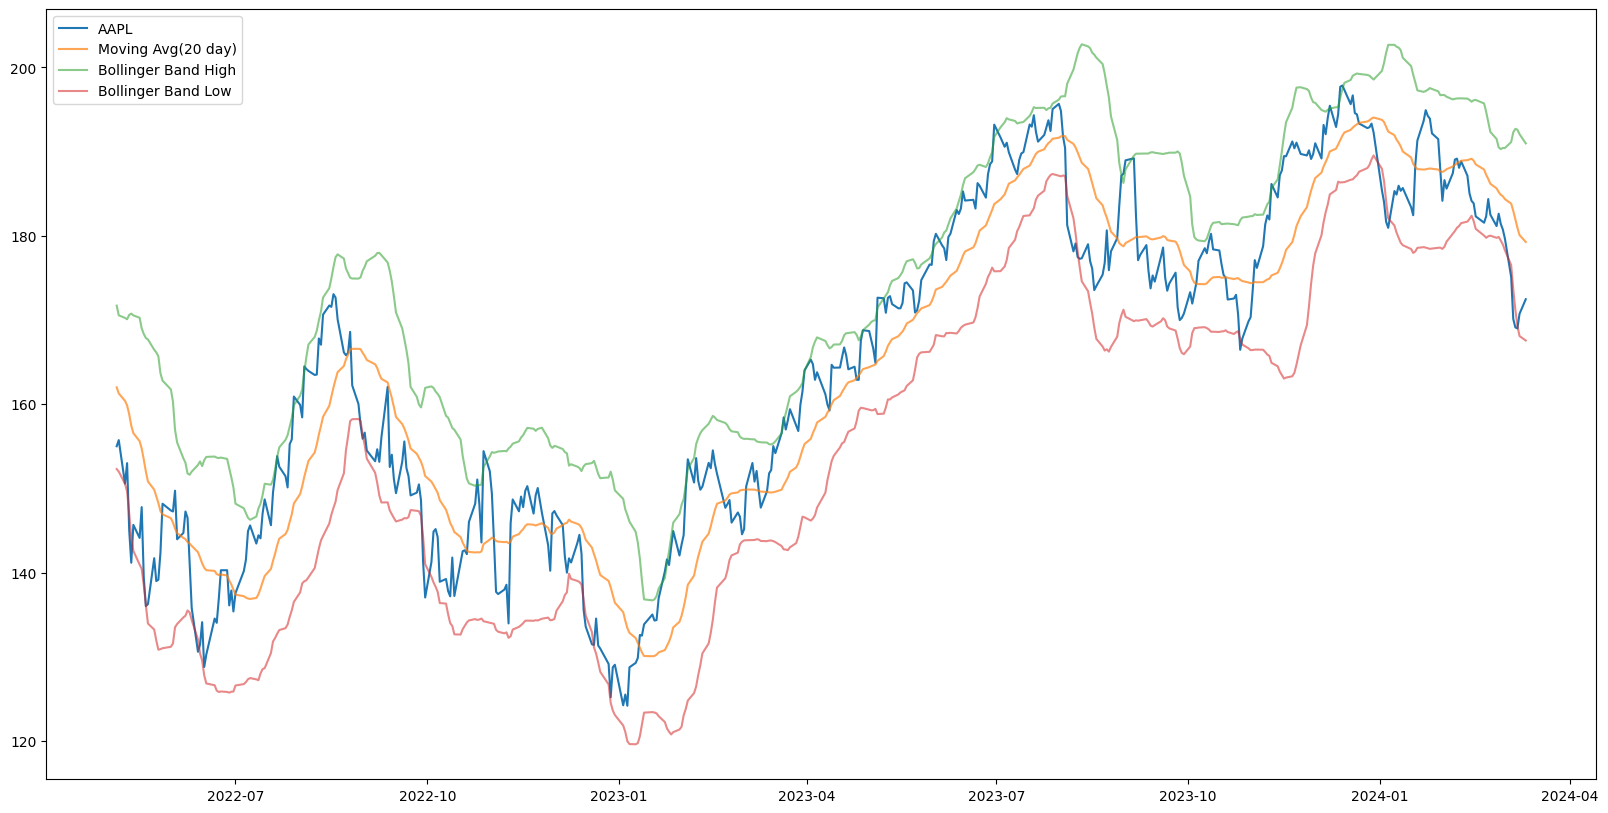

In [21]:
aapl_ta.plot_bollinger_bands()

---
# Trading Strategy
---


Combining multiple strategies in algorithmic trading is a common approach to enhance robustness and performance. Traders often use a mix of trend-following, mean-reversion, and other strategies to adapt to different market conditions. Here are some of the most common combinations of strategies that we will choose from:


1) Trend Following with Moving Averages:
    Combining a trend-following strategy using moving averages, such as the Golden Cross (short-term moving average crossing above the long-term moving average), with filters like the Relative Strength Index (RSI) to avoid overbought or oversold conditions.

2) Mean-Reversion with Bollinger Bands:

    Utilizing mean-reversion strategies with Bollinger Bands. Trades are initiated when prices move beyond standard deviations from the moving average, suggesting potential mean-reverting behavior.

3) Momentum and Trend Following:

    Integrating momentum indicators like the Moving Average Convergence Divergence (MACD) with trend-following strategies. This combination aims to capture both short-term momentum and long-term trends.
4) Breakout and Volatility:

    Combining breakout strategies with volatility measures, such as the Average True Range (ATR). This helps identify potential price breakouts and adjusts for different market conditions.

5) Dual Moving Average Crossover with RSI:

    Using a dual moving average crossover strategy along with RSI for confirmation. For example, entering a long position when the short-term moving average crosses above the long-term moving average and the RSI is below a certain threshold.

6) Statistical Arbitrage:

    Employing pairs trading or cointegration strategies to identify and exploit relative price movements between correlated assets. This involves simultaneously buying and selling related instruments to capture price divergences.

7) Machine Learning Hybrid Strategies:

    Integrating machine learning models, such as neural networks or decision trees, to enhance traditional strategies. Machine learning algorithms can adapt to complex patterns and changing market conditions.

8) Event-Driven Strategies:

    Combining event-driven strategies with technical indicators. Event-driven strategies involve reacting to specific events or news, and technical indicators can be used for entry and exit points.

9) Market Microstructure Strategies:

    Utilizing strategies based on market microstructure, such as order book analysis, bid-ask spread dynamics, and order flow analysis. These strategies are often employed in high-frequency trading.

---
## Trading Strategy 1

### Mean-Reversion with Bollinger Bands:

Utilizing mean-reversion strategies with Bollinger Bands. Trades are initiated when prices move beyond standard deviations from the moving average, suggesting potential mean-reverting behavior.

Conditions:

- Buy if:
    - Position is false (don't currently "own" the stock, no previous buy signal)
    - RSI(Relative Strength Index) is less than 30.
    - Adjusted Close price is less than the Bollnger Low Band
- Sell if:
    - Position is true ( currently "own" the stock, previous buy signal)
    - RSI(Relative Strength Index) is greater than 70.
    - Adjusted Close price is greater than the Bollnger High Band

Tracking all Buy and sell signals over the dataframe provided, this works for the backtesting, but should be applied differently for a working product providing daily recommendations etc.

In [22]:
class TradingStrategy1:
    def __init__(self, ta: TechnicalAnalysis):
        self.ta = ta
        self.Ticker = self.ta.Ticker
        self.symbol = self.ta.symbol
        self.df = self.ta.df_ta.copy(deep=True)
        self.generate_signal()
        self.generate_trades()
        # self.generate_returns()
        # self.generate_performance()

    def __str__(self):
        return self.symbol
    
    def __repr__(self):
        return self.symbol
    
    def generate_signal(self):
        conditions = [(self.df['rsi'] < 30) & (self.df['Adj Close'] < self.df['BollingerBandLow']),
                        (self.df['rsi'] > 70) & (self.df['Adj Close'] > self.df['BollingerBandHigh'])] 
        choices = ['Buy', 'Sell']
        self.df['Signal'] = np.select(conditions, choices, default='Hold')
        self.df.dropna(inplace=True)
        self.df['Signal'] = self.df['Signal'].shift(1)

    def generate_trades(self):
        self.position = False
        self.buy_dates, self.sell_dates = [], []
        self.buy_prices, self.sell_prices = [], []

        for index, row in self.df.iterrows():
            if row['Signal'] == 'Buy' and self.position == False:
                self.buy_dates.append(index)
                self.buy_prices.append(row['Open'])
                self.position = True

            elif row['Signal'] == 'Sell' and self.position == True:
                self.sell_dates.append(index)
                self.sell_prices.append(row['Open'])
                self.position = False

        self.buy_arr = self.df.loc[self.buy_dates].Open
        self.sell_arr = self.df.loc[self.sell_dates].Open

        if len(self.buy_arr) != len(self.sell_arr):
            if len(self.buy_arr) > len(self.sell_arr):
                self.buy_arr = self.buy_arr[:-1]
            else:
                self.sell_arr = self.sell_arr[:-1]

        self.trades_df = pd.DataFrame({'Buy Date': self.buy_arr.index, 'Buy Price': self.buy_arr.values})
        self.trades_df.insert(0, 'Ticker', self.symbol)
        self.trades_df['Buy RSI'] = self.df.loc[self.trades_df['Buy Date']]['rsi'].values
        self.trades_df['Buy Upper BB'] = self.df.loc[self.trades_df['Buy Date']]['upper_bb'].values
        self.trades_df['Buy Bollinger %b'] = self.df.loc[self.trades_df['Buy Date']]['Bollinger%b'].values
        self.trades_df['Buy Lower BB'] = self.df.loc[self.trades_df['Buy Date']]['lower_bb'].values
        self.trades_df['Buy vol'] = self.df.loc[self.trades_df['Buy Date']]['vol'].values
        self.trades_df['Buy Z Score'] = self.df.loc[self.trades_df['Buy Date']]['Z Score Adj Close'].values
        self.trades_df['Sell Date'] = self.sell_arr.index
        self.trades_df['Sell Price'] = self.sell_arr.values
        self.trades_df['Sell RSI'] = self.df.loc[self.trades_df['Sell Date']]['rsi'].values
        self.trades_df['Sell Upper BB'] = self.df.loc[self.trades_df['Sell Date']]['upper_bb'].values
        self.trades_df['Sell Bollinger %b'] = self.df.loc[self.trades_df['Sell Date']]['Bollinger%b'].values
        self.trades_df['Sell Lower BB'] = self.df.loc[self.trades_df['Sell Date']]['lower_bb'].values
        self.trades_df['Sell vol'] = self.df.loc[self.trades_df['Sell Date']]['vol'].values
        self.trades_df['Sell Z Score'] = self.df.loc[self.trades_df['Sell Date']]['Z Score Adj Close'].values
        self.trades_df['Profit'] = self.trades_df['Sell Price'] - self.trades_df['Buy Price']
        self.trades_df['Profit %'] = (self.trades_df['Profit'] / self.trades_df['Buy Price']) * 100
        self.trades_df['Profit %'] = self.trades_df['Profit %'].round(2)
        self.trades_df['Duration'] = self.trades_df['Sell Date'] - self.trades_df['Buy Date']
        self.trades_df['Duration'] = self.trades_df['Duration'].dt.days
        self.trades_df['Trade Number'] = range(1, len(self.trades_df) + 1)
        self.trades_df['Ticker Cum Profit'] = self.trades_df['Profit'].cumsum()
        if len(self.trades_df['Buy Price']) > 0:
            self.trades_df['Ticker Cum Profit %'] = (self.trades_df['Ticker Cum Profit'] / self.trades_df['Buy Price'].iloc[0]) * 100
        else:
            self.trades_df['Ticker Cum Profit %'] = 0
        self.trades_df['Ticker Cum Profit %'] = self.trades_df['Ticker Cum Profit %'].round(2)
        self.trades_df['Profitable'] = self.trades_df['Profit'] > 0
        self.trades_df['Profitable'] = self.trades_df['Profitable'].replace({True: 'Yes', False: 'No'})
        return self.trades_df

    def plot_chart(self):
        plt.figure(figsize=(20, 10))
        plt.plot(self.df['Adj Close'], label=self.symbol, alpha=1)
        plt.plot(self.df['BollingerMAvg'], label='Bollinger Moving Avg(20)', alpha=0.45)
        plt.plot(self.df['BollingerBandHigh'], label='Bollinger Band High', alpha=0.55)
        plt.plot(self.df['BollingerBandLow'], label='Bollinger Band Low', alpha=0.55)
        plt.scatter(self.buy_arr.index, self.buy_arr.values, label='Buy Signal', marker='^', color='green')
        plt.scatter(self.sell_arr.index, self.sell_arr.values, label='Sell Signal', marker='v', color='red')
        for i in range(len(self.buy_arr)):
            plt.text(self.buy_arr.index[i], self.buy_arr.values[i], "      $" + str(round(self.buy_arr.values[i], 2)), fontsize=10, color='g')
        for i in range(len(self.sell_arr)):
            plt.text(self.sell_arr.index[i], self.sell_arr.values[i], "      $" + str(round(self.sell_arr.values[i], 2)), fontsize=10, color='r')
        plt.title(self.symbol + ' Trading Strategy')
        plt.legend()
        plt.show()
        plt.close()
    


    
    def generate_returns(self):
        self.returns_df = self.trades_df.copy(deep=True)
        self.returns_df['Returns'] = self.returns_df['Sell Price'] - self.returns_df['Buy Price']
        self.returns_df['Returns %'] = (self.returns_df['Returns'] / self.returns_df['Buy Price']) * 100
        self.returns_df['Returns %'] = self.returns_df['Returns %'].round(2)
        self.returns_df['Returns %'] = self.returns_df['Returns %'].astype(str) + '%'
        self.returns_df['Cumulative Returns'] = self.returns_df['Returns'].cumsum()
        self.returns_df['Cumulative Returns %'] = (self.returns_df['Cumulative Returns'] / self.returns_df['Buy Price'].iloc[0]) * 100
        self.returns_df['Cumulative Returns %'] = self.returns_df['Cumulative Returns %'].shift(1)
        self.returns_df['Cumulative Returns %'].iloc[0] = 0
        self.returns_df['Cumulative Returns %'] = self.returns_df['Cumulative Returns %'].fillna(0)
        self.returns_df['Cumulative Returns %'] = self.returns_df['Cumulative Returns %'].round(2)
        self.returns_df['Cumulative Returns %'] = self.returns_df['Cumulative Returns %'].astype(str) + '%'
        self.returns_df['Trade Number'] = range(1, len(self.returns_df) + 1)
        self.returns_df['Profitable'] = self.returns_df['Returns'] > 0
        self.returns_df['Profitable'] = self.returns_df['Profitable'].replace({True: 'Yes', False: 'No'})
        return self.returns_df
    
    def generate_performance(self):
        self.performance_df = self.returns_df.copy(deep=True)
        self.performance_df['Winning Trades'] = self.performance_df['Profitable'].apply(lambda x: 1 if x == 'Yes' else 0)
        self.performance_df['Losing Trades'] = self.performance_df['Profitable'].apply(lambda x: 1 if x == 'No' else 0)
        self.performance_df['Winning Trades'] = self.performance_df['Winning Trades'].cumsum()
        self.performance_df['Losing Trades'] = self.performance_df['Losing Trades'].cumsum()
        self.performance_df['Total Trades'] = self.performance_df['Trade Number']
        self.performance_df['Win Rate'] = (self.performance_df['Winning Trades'] / self.performance_df['Total Trades']) * 100
        self.performance_df['Loss Rate'] = (self.performance_df['Losing Trades'] / self.performance_df['Total Trades']) * 100
        self.performance_df['Win Rate'] = self.performance_df['Win Rate'].round(2)
        self.performance_df['Loss Rate'] = self.performance_df['Loss Rate'].round(2)
        self.performance_df['Win Rate'] = self.performance_df['Win Rate'].shift(1)
        self.performance_df['Loss Rate'] = self.performance_df['Loss Rate'].shift(1)
        self.performance_df['Win Rate'].iloc[0] = 0
        self.performance_df['Loss Rate'].iloc[0] = 0
        self.performance_df['Win Rate'] = self.performance_df['Win Rate'].fillna(0)
        self.performance_df['Loss Rate'] = self.performance_df['Loss Rate'].fillna(0)
        self.performance_df['Win Rate'] = self.performance_df['Win Rate'].astype(str) + '%'
        self.performance_df['Loss Rate'] = self.performance_df['Loss Rate'].astype(str) + '%'
        self.performance_df['Biggest Win %'] = self.performance_df['Returns %'].max()
        self.performance_df['Biggest Loss %'] = self.performance_df['Returns %'].min()
        return self.performance_df


In [23]:
aapl_ts = TradingStrategy1(aapl_ta)

print(aapl_ts)

AAPL


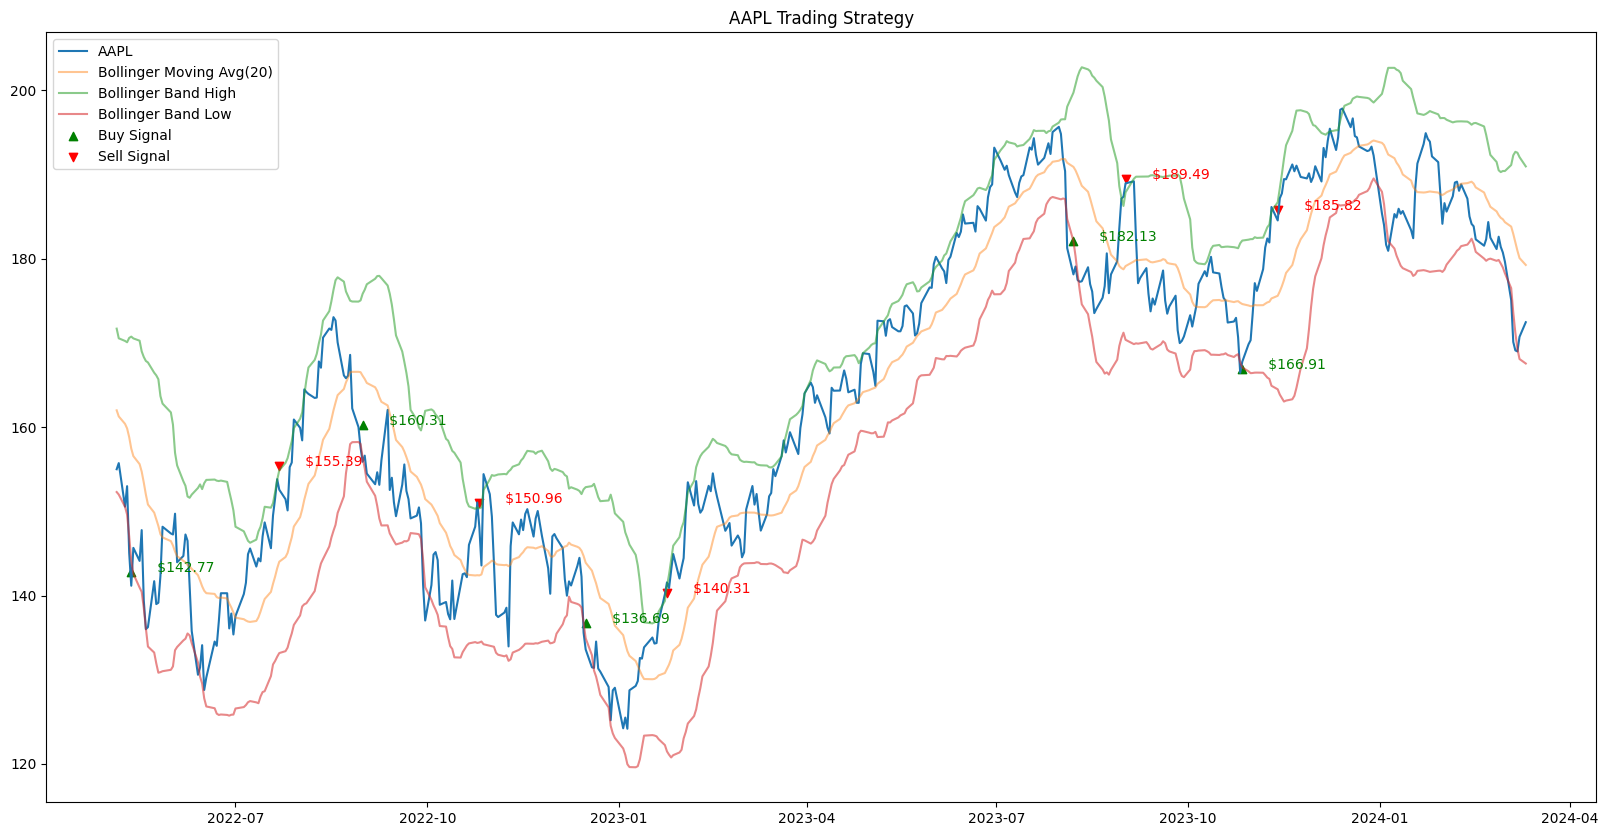

In [24]:
aapl_ts.plot_chart()

In [25]:
aapl_ts.trades_df


,Ticker,Buy Date,Buy Price,Buy RSI,Buy Upper BB,Buy Bollinger %b,Buy Lower BB,Buy vol,Buy Z Score,Sell Date,...,Sell Lower BB,Sell vol,Sell Z Score,Profit,Profit %,Duration,Trade Number,Ticker Cum Profit,Ticker Cum Profit %,Profitable
0,AAPL,2022-05-12,142.77,23.742456,170.757766,-0.127949,144.142234,6.653883,-2.448195,2022-07-22,...,133.161597,5.425952,1.576958,12.62,8.84,71,1,12.62,8.84,Yes
1,AAPL,2022-08-31,160.31,19.349980,175.845103,-0.037839,156.361897,4.870802,-2.096883,2022-10-26,...,134.417377,3.984561,1.428890,-9.35,-5.83,56,2,3.27,2.29,No
2,AAPL,2022-12-16,136.69,22.485427,152.872168,-0.088867,134.917832,4.488584,-2.295824,2023-01-24,...,121.477699,4.910900,2.089332,3.62,2.65,39,3,6.89,4.83,Yes
3,AAPL,2023-08-07,182.13,12.819747,199.744037,-0.242816,182.101963,4.410519,-2.896031,2023-09-01,...,170.379539,4.379230,2.245143,7.36,4.04,25,4,14.25,9.98,Yes
4,AAPL,2023-10-27,166.91,24.612135,182.167979,0.033960,167.090021,3.769490,-1.816957,2023-11-13,...,164.498024,5.554738,1.611687,18.91,11.33,17,5,33.16,23.23,Yes


In [26]:
aapl_ts.generate_returns()

/tmp/ipykernel_2327/1127944842.py:112: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.returns_df['Cumulative Returns %'].iloc[0] = 0
/tmp/ipykernel_2327/1127944842.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,Ticker,Buy Date,Buy Price,Buy RSI,Buy Upper BB,Buy Bollinger %b,Buy Lower BB,Buy vol,Buy Z Score,Sell Date,...,Profit %,Duration,Trade Number,Ticker Cum Profit,Ticker Cum Profit %,Profitable,Returns,Returns %,Cumulative Returns,Cumulative Returns %
0,AAPL,2022-05-12,142.77,23.742456,170.757766,-0.127949,144.142234,6.653883,-2.448195,2022-07-22,...,8.84,71,1,12.62,8.84,Yes,12.62,8.84%,12.62,0.0%
1,AAPL,2022-08-31,160.31,19.349980,175.845103,-0.037839,156.361897,4.870802,-2.096883,2022-10-26,...,-5.83,56,2,3.27,2.29,No,-9.35,-5.83%,3.27,8.84%
2,AAPL,2022-12-16,136.69,22.485427,152.872168,-0.088867,134.917832,4.488584,-2.295824,2023-01-24,...,2.65,39,3,6.89,4.83,Yes,3.62,2.65%,6.89,2.29%
3,AAPL,2023-08-07,182.13,12.819747,199.744037,-0.242816,182.101963,4.410519,-2.896031,2023-09-01,...,4.04,25,4,14.25,9.98,Yes,7.36,4.04%,14.25,4.83%
4,AAPL,2023-10-27,166.91,24.612135,182.167979,0.033960,167.090021,3.769490,-1.816957,2023-11-13,...,11.33,17,5,33.16,23.23,Yes,18.91,11.33%,33.16,9.98%


In [27]:
aapl_ts.generate_performance()

/tmp/ipykernel_2327/1127944842.py:134: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.performance_df['Win Rate'].iloc[0] = 0
/tmp/ipykernel_2327/1127944842.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

,Ticker,Buy Date,Buy Price,Buy RSI,Buy Upper BB,Buy Bollinger %b,Buy Lower BB,Buy vol,Buy Z Score,Sell Date,...,Returns %,Cumulative Returns,Cumulative Returns %,Winning Trades,Losing Trades,Total Trades,Win Rate,Loss Rate,Biggest Win %,Biggest Loss %
0,AAPL,2022-05-12,142.77,23.742456,170.757766,-0.127949,144.142234,6.653883,-2.448195,2022-07-22,...,8.84%,12.62,0.0%,1,0,1,0.0%,0.0%,8.84%,-5.83%
1,AAPL,2022-08-31,160.31,19.349980,175.845103,-0.037839,156.361897,4.870802,-2.096883,2022-10-26,...,-5.83%,3.27,8.84%,1,1,2,100.0%,0.0%,8.84%,-5.83%
2,AAPL,2022-12-16,136.69,22.485427,152.872168,-0.088867,134.917832,4.488584,-2.295824,2023-01-24,...,2.65%,6.89,2.29%,2,1,3,50.0%,50.0%,8.84%,-5.83%
3,AAPL,2023-08-07,182.13,12.819747,199.744037,-0.242816,182.101963,4.410519,-2.896031,2023-09-01,...,4.04%,14.25,4.83%,3,1,4,66.67%,33.33%,8.84%,-5.83%
4,AAPL,2023-10-27,166.91,24.612135,182.167979,0.033960,167.090021,3.769490,-1.816957,2023-11-13,...,11.33%,33.16,9.98%,4,1,5,75.0%,25.0%,8.84%,-5.83%


### BackTesting on S&P 500



In [35]:
stock_df = pd.DataFrame()
tradingstrategy1_df = pd.DataFrame()

for ticker in tickers500[1:500]:
    stock = Ticker(ticker, start='2022-01-31', end='2024-01-31')
    stock_df = stock_df._append(stock.df)
    techA = TechnicalAnalysis(stock)
    tradingS = TradingStrategy1(techA)
    tradingstrategy1_df = tradingstrategy1_df._append(tradingS.trades_df)

stock_df.reset_index(drop=True, inplace=True)
stock_df.to_csv('BackTestData/stock_df.csv', index=False)

tradingstrategy1_df.sort_values(by=['Sell Date'], ascending=[True], inplace=True)
tradingstrategy1_df.reset_index(drop=True, inplace=True)
tradingstrategy1_df.to_csv('tradingstrategy1.csv', index=False)

tradingstrategy1_df['Profitable'].value_counts()

Profitable
Yes    1583
No      897
Name: count, dtype: int64

In [36]:
def generate_returns(dataframe: pd.DataFrame):
    returns_df = dataframe.copy(deep=True)
    returns_df['Returns'] = returns_df['Sell Price'] - returns_df['Buy Price']
    returns_df['Returns %'] = (returns_df['Returns'] / returns_df['Buy Price']) * 100
    returns_df['Cumulative Returns'] = returns_df['Returns'].cumsum()
    returns_df['Cumulative Returns %'] = (returns_df['Cumulative Returns'] / returns_df['Buy Price'].iloc[0]) * 100
    returns_df['Cumulative Returns %'] = returns_df['Cumulative Returns %'].shift(1)
    returns_df['Cumulative Returns %'].iloc[0] = 0
    returns_df['Cumulative Returns %'] = returns_df['Cumulative Returns %'].fillna(0)
    returns_df['Cumulative Returns %'] = returns_df['Cumulative Returns %'].round(2)
    returns_df['Trade Number'] = range(1, len(returns_df) + 1)
    returns_df['Profitable'] = returns_df['Returns'] > 0
    returns_df['Profitable'] = returns_df['Profitable'].replace({True: 'Yes', False: 'No'})
    return returns_df


/tmp/ipykernel_2327/3272018276.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  returns_df['Cumulative Returns %'].iloc[0] = 0
/tmp/ipykernel_2327/3272018276.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

<Axes: title={'center': 'Cumulative Returns %'}>

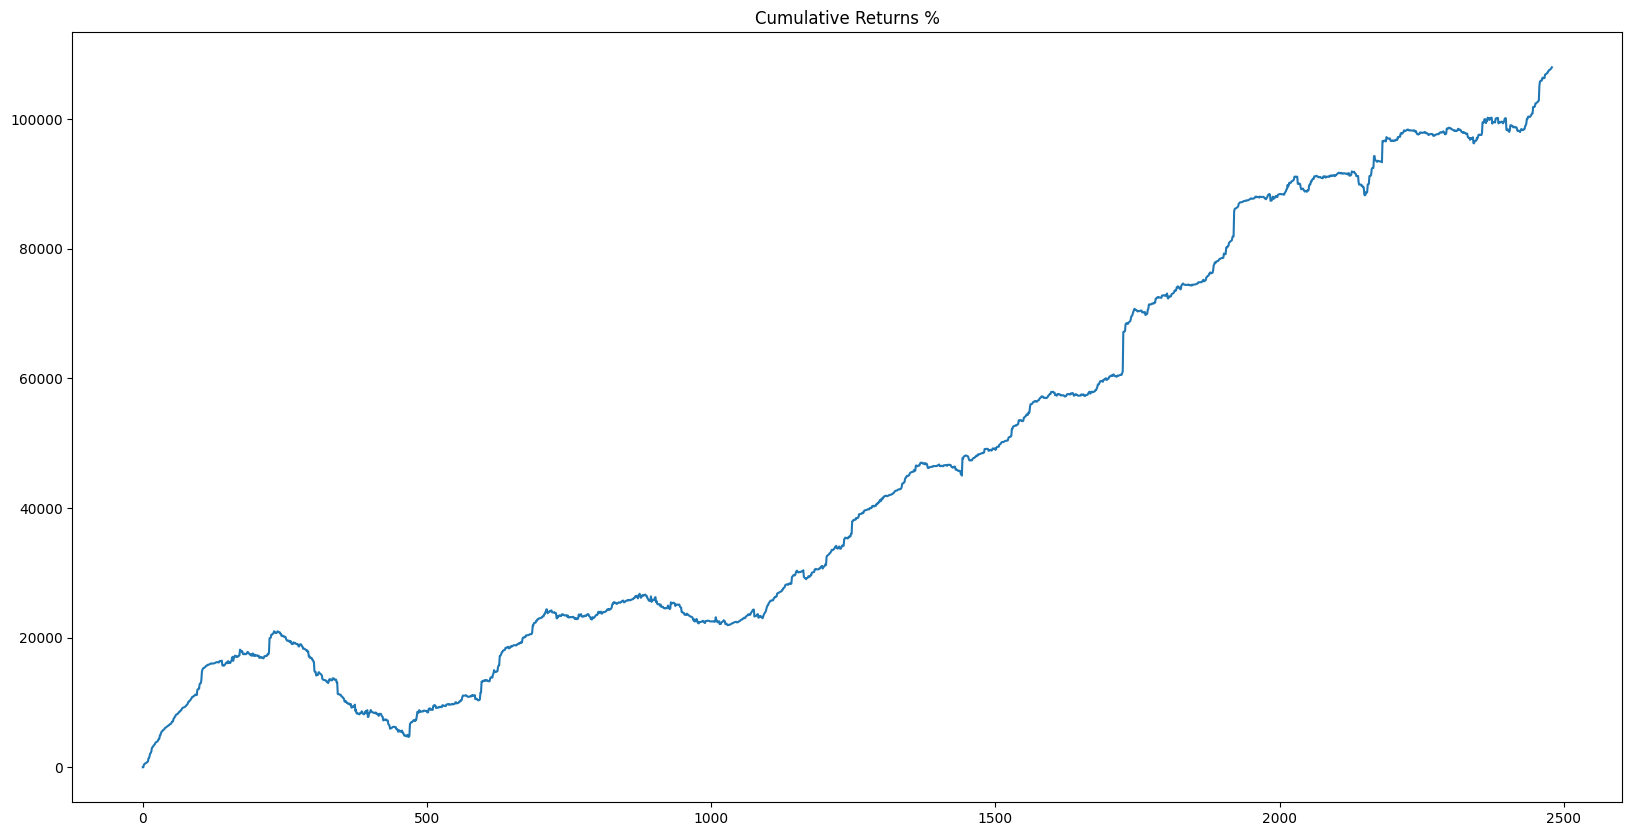

In [37]:
tradingstrategy1returns_df = generate_returns(tradingstrategy1_df)

tradingstrategy1returns_df.to_csv('tradingstrategy1returns.csv', index=False)

tradingstrategy1returns_df['Cumulative Returns %'].plot(figsize=(20, 10), title='Cumulative Returns %')

In [38]:

def generate_performance(dataframe: pd.DataFrame):
    performance_df = dataframe.copy(deep=True)
    performance_df['Winning Trades'] = performance_df['Profitable'].apply(lambda x: 1 if x == 'Yes' else 0)
    performance_df['Losing Trades'] = performance_df['Profitable'].apply(lambda x: 1 if x == 'No' else 0)
    performance_df['Winning Trades'] = performance_df['Winning Trades'].cumsum()
    performance_df['Losing Trades'] = performance_df['Losing Trades'].cumsum()
    performance_df['Total Trades'] = performance_df['Trade Number']
    performance_df['Win Rate'] = (performance_df['Winning Trades'] / performance_df['Total Trades']) * 100
    performance_df['Loss Rate'] = (performance_df['Losing Trades'] / performance_df['Total Trades']) * 100
    performance_df['Win Rate'] = performance_df['Win Rate'].round(2)
    performance_df['Loss Rate'] = performance_df['Loss Rate'].round(2)
    performance_df['Win Rate'] = performance_df['Win Rate'].shift(1)
    performance_df['Loss Rate'] = performance_df['Loss Rate'].shift(1)
    performance_df['Win Rate'].iloc[0] = 0
    performance_df['Loss Rate'].iloc[0] = 0
    performance_df['Win Rate'] = performance_df['Win Rate'].fillna(0)
    performance_df['Loss Rate'] = performance_df['Loss Rate'].fillna(0)
    performance_df['Win Rate'] = performance_df['Win Rate'].astype(str) + '%'
    performance_df['Loss Rate'] = performance_df['Loss Rate'].astype(str) + '%'
    return performance_df

In [39]:
tradingstrategy1performance_df = generate_performance(tradingstrategy1returns_df)

tradingstrategy1performance_df.to_csv('tradingstrategy1performance_df.csv', index=False)

/tmp/ipykernel_2327/725295386.py:14: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  performance_df['Win Rate'].iloc[0] = 0
/tmp/ipykernel_2327/725295386.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [33]:
class Positions:
    def __init__(self):
        self.positions = {}
        self.cash = 1000000
        self.equity = 0
        self.profit = 0
        self.total_value = 0
        self.total_profit = 0
        self.total_equity = 0
        self.trades = {date, ticker, amount, price, type}

    def buy(self, ticker: Ticker, amount: int):
        if self.cash < amount:
            print("Not enough cash to buy ", ticker.symbol)
        else:
            self.cash -= amount
            self.equity += amount
            self.positions[ticker.symbol] = amount
            print("Bought ", amount, " shares of ", ticker.symbol)

    def sell(self, ticker: Ticker, amount: int):
        if ticker.symbol not in self.positions:
            print("No position in ", ticker.symbol)
        elif self.positions[ticker.symbol] < amount:
            print("Not enough shares to sell")
        else:
            self.cash += amount
            self.equity -= amount
            self.positions[ticker.symbol] -= amount
            print("Sold ", amount, " shares of ", ticker.symbol)

    # def calculate_profit(self, ticker: Ticker):
    #     self.profit = (ticker.df['Adj Close'].iloc[-1] - ticker.df['Adj Close'].iloc[0]) * self.positions[ticker.symbol]
    #     return self.profit

    # def calculate_total_value(self):
    #     self.total_value = self.cash + self.equity
    #     return self.total_value

    # def calculate_total_profit(self):
    #     self.total_profit = self.total_value - 1000000
    #     return self.total_profit
    
    #     def buy_and_hold(self):
    #     self.df['Buy and Hold'] = self.df['Adj Close'] / self.df['Adj Close'].iloc[0]
    #     return self.df

    # def generate_returns(self):
    #     self.df['Returns'] = self.df['Adj Close'].pct_change()
    #     self.df.dropna(inplace=True)
    #     return self.df

    # def generate_sharpe_ratio(self):
    #     self.sharpe_ratio = (self.df['Returns'].mean() - 0.015) / self.df['Returns'].std()
    #     return self.sharpe_ratio

In [34]:


# aapl_ta.generate_prophet_forecast(frame = 'Adj Close', period=90)
# aapl_ta.generate_prophet_forecast(frame = 'Open')

# aapl_ta.autocorrelation_plot()

# aapl_ta.generate_correlation_matrix()

# [FB Prophet](https://facebook.github.io/prophet/)
"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."